In [1]:
import json, os, re, gc, torch
from pathlib import Path
from tqdm.auto import tqdm
import collections
import matplotlib.pyplot as plt
import numpy as np

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    GenerationConfig,
)

In [2]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Device 0: NVIDIA H100 80GB HBM3
Device 1: NVIDIA H100 80GB HBM3
Device 2: NVIDIA H100 80GB HBM3
Device 3: NVIDIA H100 80GB HBM3


### Configuration

In [8]:
DATA_PATH = Path('dataset.json')
OUT_DIR = Path('behavioral_results')

MODEL_IDS = {
    'llama3-8b-inst' : 'meta-llama/Meta-Llama-3-8B-Instruct',
    'llama3-8b'       : 'meta-llama/Meta-Llama-3-8B',
    'qwen2.5-3b-inst': 'Qwen/Qwen2.5-3B-Instruct',
    'qwen2.5-3b': 'Qwen/Qwen2.5-3B',
    'llama3-70b-inst': 'meta-llama/Meta-Llama-3-70B-Instruct',
    # 'llama3-70b'      : 'meta-llama/Meta-Llama-3-70B',
}

GEN_CFG = GenerationConfig(max_new_tokens=3, do_sample=False, max_length=None)

In [3]:
INT_RE = re.compile(r"\d+")

def extract_int(text: str):
    """Return first integer inside parentheses, or None."""
    m = INT_RE.search(text)
    return int(m.group()) if m else None


In [4]:
assert DATA_PATH.exists(), f'Dataset not found: {DATA_PATH}'
with DATA_PATH.open() as f:
    data = json.load(f)
prompts  = [ex['prompt'] for ex in data]
answers  = [ex['answer'] for ex in data]
print(f'Loaded {len(prompts):,} prompts')

Loaded 5,000 prompts


### Run Evaluation

In [6]:
OUT_DIR.mkdir(exist_ok=True)
results_summary = {}

for nick, model_id in MODEL_IDS.items():
    print(f'\n=== Evaluating {nick} ===')
    subdir = OUT_DIR / nick
    subdir.mkdir(parents=True, exist_ok=True)
    pred_file = subdir / 'predictions.jsonl'

    tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
    tokenizer.padding_side = 'left'
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map='auto' if torch.cuda.is_available() else None,
        trust_remote_code=True,
    )

    correct = 0
    with pred_file.open('w') as fout:
        for prompt, gold in tqdm(zip(prompts, answers), total=len(prompts), ncols=80):
            inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
            outputs = model.generate(**inputs, **GEN_CFG.to_dict())
            generation = tokenizer.decode(outputs[0][inputs['input_ids'].size(1):], skip_special_tokens=True)
            pred = extract_int(generation)
            correct += (pred == gold)
            fout.write(json.dumps({'prompt': prompt, 'gold': gold, 'raw': generation.strip(), 'pred': pred}) + '\n')

    acc = correct / len(prompts)
    results_summary[nick] = acc
    print(f'Accuracy for {nick}: {acc:.3%}')

    # Free GPU / RAM
    del model; del tokenizer; torch.cuda.empty_cache(); gc.collect()


=== Evaluating llama3-8b-inst ===


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|                                                  | 0/5000 [00:00<?, ?it/s]

Accuracy for llama3-8b-inst: 73.520%

=== Evaluating llama3-8b ===


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|                                                  | 0/5000 [00:00<?, ?it/s]

Accuracy for llama3-8b: 36.300%

=== Evaluating qwen2.5-3b-inst ===


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|                                                  | 0/5000 [00:00<?, ?it/s]

Accuracy for qwen2.5-3b-inst: 4.660%

=== Evaluating qwen2.5-3b ===


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|                                                  | 0/5000 [00:00<?, ?it/s]

Accuracy for qwen2.5-3b: 0.660%

=== Evaluating llama3-70b-inst ===


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|                                                  | 0/5000 [00:00<?, ?it/s]

Accuracy for llama3-70b-inst: 91.060%

=== Evaluating llama3-70b ===


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the cpu.


  0%|                                                  | 0/5000 [00:00<?, ?it/s]

OSError: [Errno 116] Stale file handle

In [ ]:
# Finsihed the above running llama 3 70B

## Behavioral Analysis

In [11]:
RESULTS_DIR = Path("behavioral_results")

MODELS = [
    "llama3-8b",
    "llama3-8b-inst",
    "llama3-70b-inst",
    "qwen2.5-3b",
    "qwen2.5-3b-inst",
]

COLORS = {
    "llama3-8b"      : "#9ecae1",   # light blue
    "llama3-8b-inst" : "#3182bd",   # dark  blue
    "llama3-70b-inst": "#31a354",   # dark  green
    "qwen2.5-3b"     : "#fdd0a2",   # light orange
    "qwen2.5-3b-inst": "#fc8d59",   # dark  orange
}


with DATA_PATH.open() as f:
    base_data = json.load(f)

meta_by_prompt = {d["prompt"]: (d["type"], d["list_length"]) for d in base_data}
all_types      = sorted({d["type"]        for d in base_data})
all_lengths    = sorted({d["list_length"] for d in base_data})

overall_acc = {}
type_acc    = {t: {} for t in all_types}
len_acc     = {L: {} for L in all_lengths}


for m in MODELS:
    pred_path = RESULTS_DIR / m / "predictions.jsonl"
    if not pred_path.exists():
        print(f"[!] {pred_path} not found – skipping")
        continue

    tot = correct = 0
    type_tot = collections.Counter()
    type_ok  = collections.Counter()
    len_tot  = collections.Counter()
    len_ok   = collections.Counter()

    with pred_path.open() as f:
        for line in f:
            rec     = json.loads(line)
            prompt  = rec["prompt"]
            gold    = rec["gold"]
            pred    = rec["pred"]

            wtype, L = meta_by_prompt[prompt]

            tot                 += 1
            type_tot[wtype]     += 1
            len_tot[L]          += 1

            if pred == gold:
                correct            += 1
                type_ok[wtype]     += 1
                len_ok[L]          += 1

    overall_acc[m] = correct / tot
    for t in all_types:
        type_acc[t][m] = type_ok[t] / type_tot[t]
    for L in all_lengths:
        len_acc[L][m]  = len_ok[L]  / len_tot[L]

=====Overall Accuracies=====
llama3-8b: 0.363
llama3-8b-inst: 0.7352
llama3-70b-inst: 0.9106
qwen2.5-3b: 0.0066
qwen2.5-3b-inst: 0.0466


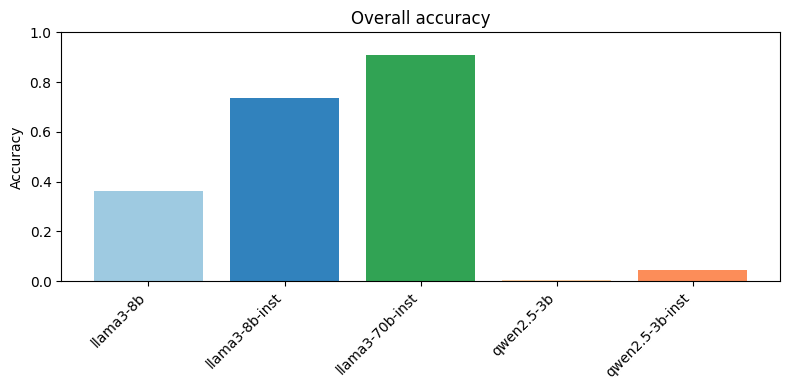

In [12]:
print("=====Overall Accuracies=====")
for m in MODELS:
    print(f"{m}: {overall_acc[m]}")

plt.figure(figsize=(8,4))
x = np.arange(len(MODELS))
plt.bar(x,
        [overall_acc[m] for m in MODELS],
        color=[COLORS[m] for m in MODELS])
plt.xticks(x, MODELS, rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Overall accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('behavioral_results/overall_behavioral_acc.png', dpi=150)
plt.show()

=====Type Accuracies=====
animal: {'llama3-8b': 0.3925233644859813, 'llama3-8b-inst': 0.7383177570093458, 'llama3-70b-inst': 0.9865005192107996, 'qwen2.5-3b': 0.0020768431983385254, 'qwen2.5-3b-inst': 0.016614745586708203}
fruit: {'llama3-8b': 0.4609375, 'llama3-8b-inst': 0.822265625, 'llama3-70b-inst': 0.974609375, 'qwen2.5-3b': 0.0068359375, 'qwen2.5-3b-inst': 0.05859375}
furniture: {'llama3-8b': 0.3106295149638803, 'llama3-8b-inst': 0.7223942208462333, 'llama3-70b-inst': 0.8235294117647058, 'qwen2.5-3b': 0.007223942208462332, 'qwen2.5-3b-inst': 0.043343653250773995}
instrument: {'llama3-8b': 0.3254938852304798, 'llama3-8b-inst': 0.7507055503292568, 'llama3-70b-inst': 0.9341486359360301, 'qwen2.5-3b': 0.00940733772342427, 'qwen2.5-3b-inst': 0.05079962370649106}
vehicle: {'llama3-8b': 0.3241590214067278, 'llama3-8b-inst': 0.6371049949031601, 'llama3-70b-inst': 0.8297655453618756, 'qwen2.5-3b': 0.007135575942915392, 'qwen2.5-3b-inst': 0.06218144750254842}


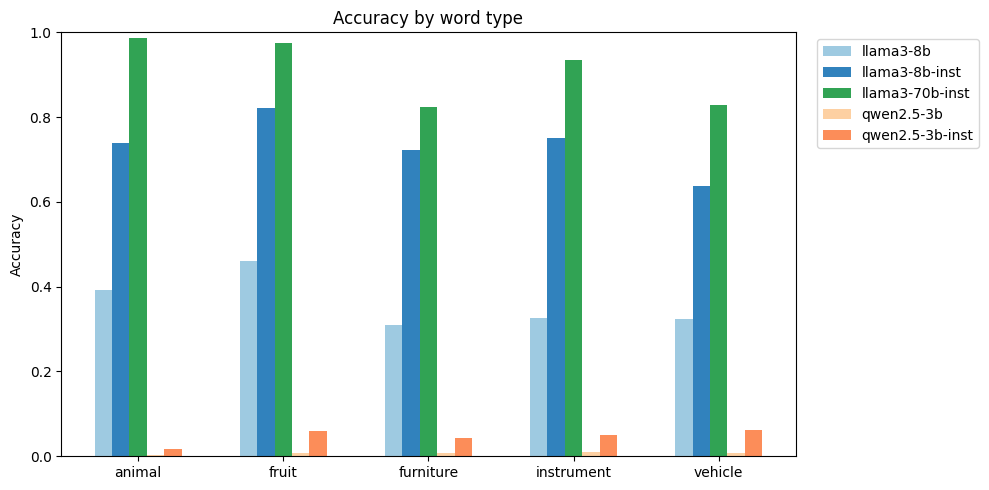

In [13]:
print("=====Type Accuracies=====")
for t in all_types:
    print(f"{t}: {type_acc[t]}")

plt.figure(figsize=(10,5))
bar_w = 0.12
centres = np.arange(len(all_types))

for i, m in enumerate(MODELS):
    plt.bar(centres + (i - len(MODELS)/2)*bar_w + bar_w/2,
            [type_acc[t].get(m, 0) for t in all_types],
            width=bar_w, color=COLORS[m], label=m)

plt.xticks(centres, all_types)
plt.ylabel("Accuracy")
plt.title("Accuracy by word type")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig('behavioral_results/word_behavioral_acc.png', dpi=150)
plt.show()

=====List Length Accuracies=====
6: {'llama3-8b': 0.5445682451253482, 'llama3-8b-inst': 0.8690807799442897, 'llama3-70b-inst': 0.9568245125348189, 'qwen2.5-3b': 0.01532033426183844, 'qwen2.5-3b-inst': 0.0807799442896936}
7: {'llama3-8b': 0.4043478260869565, 'llama3-8b-inst': 0.8521739130434782, 'llama3-70b-inst': 0.927536231884058, 'qwen2.5-3b': 0.010144927536231883, 'qwen2.5-3b-inst': 0.0536231884057971}
8: {'llama3-8b': 0.34156378600823045, 'llama3-8b-inst': 0.7777777777777778, 'llama3-70b-inst': 0.9012345679012346, 'qwen2.5-3b': 0.00823045267489712, 'qwen2.5-3b-inst': 0.027434842249657063}
9: {'llama3-8b': 0.3138888888888889, 'llama3-8b-inst': 0.6972222222222222, 'llama3-70b-inst': 0.8972222222222223, 'qwen2.5-3b': 0.005555555555555556, 'qwen2.5-3b-inst': 0.04722222222222222}
10: {'llama3-8b': 0.32751091703056767, 'llama3-8b-inst': 0.6739446870451238, 'llama3-70b-inst': 0.8864628820960698, 'qwen2.5-3b': 0.001455604075691412, 'qwen2.5-3b-inst': 0.042212518195050945}
11: {'llama3-8b':

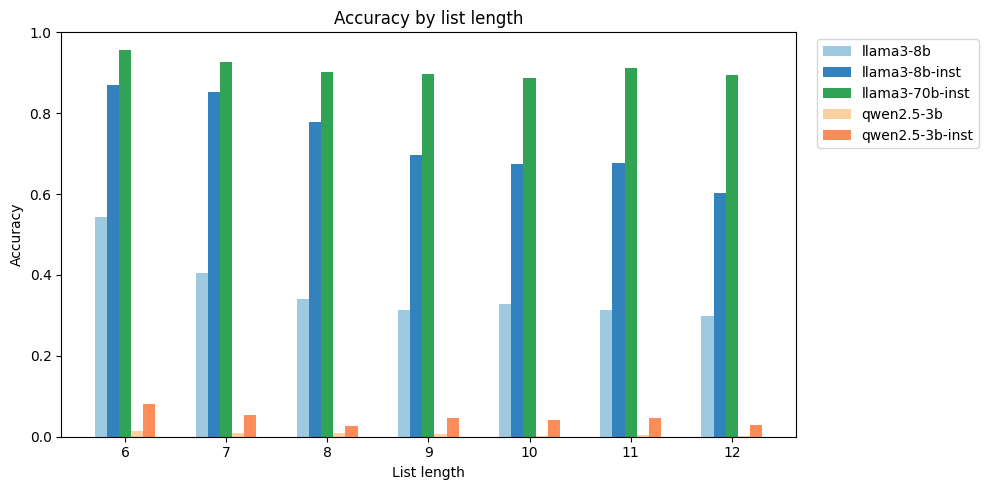

In [14]:
print("=====List Length Accuracies=====")
for L in all_lengths:
    print(f"{L}: {len_acc[L]}")

plt.figure(figsize=(10,5))
centres = np.arange(len(all_lengths))

for i, m in enumerate(MODELS):
    plt.bar(centres + (i - len(MODELS)/2)*bar_w + bar_w/2,
            [len_acc[L].get(m, 0) for L in all_lengths],
            width=bar_w, color=COLORS[m], label=m)

plt.xticks(centres, all_lengths)
plt.xlabel("List length")
plt.ylabel("Accuracy")
plt.title("Accuracy by list length")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig('behavioral_results/length_behavioral_acc.png', dpi=150)
plt.show()